In [18]:
ENV["Code"] = "../../Code"
[push!(LOAD_PATH, string(ENV["Code"],"/", ii)) for ii in readdir(ENV["Code"])]

using DataFrames
using Seaborn
using NoLongerProblems_Pandas
using NoLongerProblems
using CSV
using Seaborn
import Pandas
using PrettyPlotting
using NoLongerProblems_Pandas

include("../Databases/Cuartero2018.jl")

fpkm = Cuartero2018.get_mean_FPKM();

tab = CSV.read("smFISH_MEAN.csv", DataFrames.DataFrame)
tab[!,:Sample_Gene] = tab[!,:Sample] .*"__".*tab[!,:Gene]

meantab = DataFrames.DataFrame(Sample_Gene = unique(tab[!,:Sample_Gene]))
meantab[!,:MeanCounts] = [mean(tab[tab[!,:Sample_Gene] .== ii, :MeanCounts]) for ii in meantab[!,:Sample_Gene]]
meantab[!,:Sample] = [split(ii, "__")[1] for ii in meantab[!,:Sample_Gene] ]
meantab[!,:Gene] = [split(ii, "__")[2] for ii in meantab[!,:Sample_Gene] ]

for name in names(fpkm)
    if startswith(string(name), "FL") 
      rename!(fpkm, Symbol(string(name))=>Symbol(replace(string(name), "FL"=> "Rad21KO")))
    end
end

fpkms = []
for ii in meantab[!,:Sample_Gene]
    samp = Symbol(split(ii, "__")[1])
    geneind = fpkm[!,:GeneSymbol].==split(ii, "__")[2]
     push!(fpkms, fpkm[geneind, samp][1])
end

meantab[!,:MeanFPKM] = fpkms

36-element Vector{Any}:
  117.85302100700666
    0.1651281359987704
 1361.0449828303633
   82.40987800470474
  187.27493174515834
 1382.9695182559565
  159.717725924542
  129.37119155895343
 2772.51175247396
   41.7577500246716
    0.17102095891089633
 1322.5391341049217
   43.1518472550812
    ⋮
  115.5306113738328
  369.303805937832
  521.2281792132563
    7.268815196172507
   67.0275225787938
   32.85439246988005
   97.039061143036
  302.3368906759477
  563.0105193819323
  198.54641251918602
  118.78094102080588
  518.707544727877

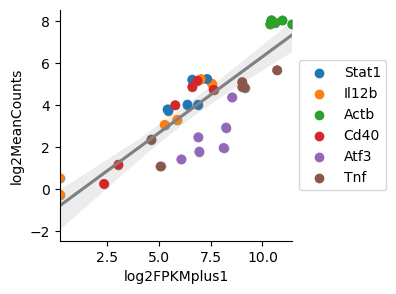

In [18]:

meantab[!,:log2MeanCounts] = log2.(meantab[!,:MeanCounts])
meantab[!,:log2FPKMplus1] = log2.(meantab[!,:MeanFPKM].+1)
pd = Pandas.DataFrame(meantab)
using PyCall
figure(figsize = (3, 3))
py"""
import seaborn as sns
sns.regplot(data = $pd, x = "log2FPKMplus1", y = "log2MeanCounts", color = "grey")
sns.scatterplot(data = $pd, x = "log2FPKMplus1", y = "log2MeanCounts", hue = "Gene", s = 50, linewidth = 0)


"""

     
pretty_axes2()

legend_out_of_plot()

savefig("log2FPKM_log2MeanCounts.svg")


In [7]:
using RCall

In [8]:
R"""
tb <- $meantab
cor.test(tb$log2MeanCounts, tb$log2FPKM)
"""



RObject{VecSxp}

	Pearson's product-moment correlation

data:  tb$log2MeanCounts and tb$log2FPKM
t = 9.7105, df = 34, p-value = 2.462e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7361057 0.9252452
sample estimates:
      cor 
0.8573117 



In [11]:
new_df = DataFrames.DataFrame()

tab = CSV.read("smFISH_MEAN_CV_Overdispersion.csv", DataFrame)
tab[:Sample_Gene] = tab[:Sample] .*"__".*tab[:Gene]


rep1 = tab[tab[:Rep].== 1, [:Sample_Gene, :MeanCounts]]; rename!(rep1, :MeanCounts =>:Rep1)
rep2 = tab[tab[:Rep].== 2, [:Sample_Gene, :MeanCounts]]; rename!(rep2, :MeanCounts =>:Rep2)
rep3 = tab[tab[:Rep].== 3, [:Sample_Gene, :MeanCounts]]; rename!(rep3, :MeanCounts =>:Rep3)

reps = join(join(rep1, rep2, on =:Sample_Gene), rep3, on=:Sample_Gene)

reps[:Gene] = [split(ii, "__")[2] for ii in reps[:Sample_Gene] ]

set1 = ["Actb", "Il12b", "Stat1"]

exps1 = reps[[in(ii, set1) for ii in  reps[:Gene]], :]

exps2 = reps[[!in(ii, set1) for ii in  reps[:Gene]], :]

deletecols!(exps1, :Sample_Gene)
deletecols!(exps2, :Sample_Gene)
deletecols!(exps1, :Gene)
deletecols!(exps2, :Gene)

CSV.write("cormatset1.csv", exps1)

CSV.write("cormatset2.csv", exps2)


ArgumentError: ArgumentError: syntax df[column] is not supported use df[!, column] instead

In [12]:
names(tab)

12-element Array{String,1}:
 "Column1"
 "Rep_Sample"
 "Rep"
 "Sample"
 "Genotype"
 "Timepoint"
 "Gene"
 "MeanCounts"
 "CV"
 "CV2"
 "FANO"
 "Overdispersion"